In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
#
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [2]:
TRAIN_DIR = '/kaggle/input/face-expression-recognition-dataset/images/train/'
TEST_DIR = '/kaggle/input/face-expression-recognition-dataset/images/validation/'

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [4]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/face-expression-recognition-data...,sad
1,/kaggle/input/face-expression-recognition-data...,fear
2,/kaggle/input/face-expression-recognition-data...,sad
3,/kaggle/input/face-expression-recognition-data...,neutral
4,/kaggle/input/face-expression-recognition-data...,neutral


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/face-expression-recognition-data...,surprise
1,/kaggle/input/face-expression-recognition-data...,surprise
2,/kaggle/input/face-expression-recognition-data...,surprise
3,/kaggle/input/face-expression-recognition-data...,surprise
4,/kaggle/input/face-expression-recognition-data...,surprise


<AxesSubplot:xlabel='label', ylabel='count'>

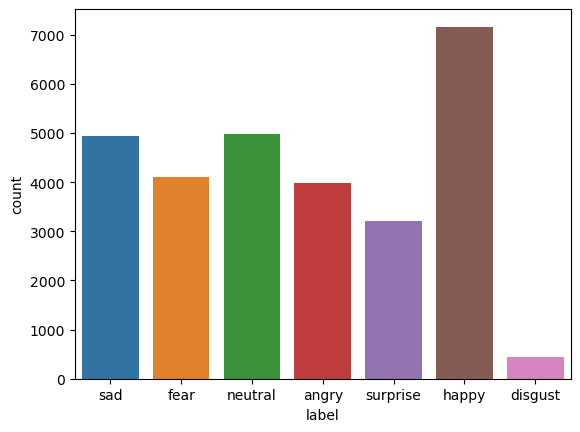

In [6]:
sns.countplot(train , x = 'label' )

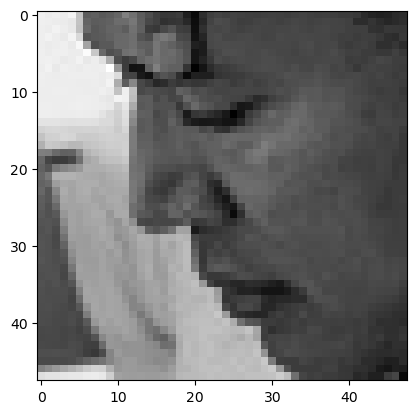

In [8]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

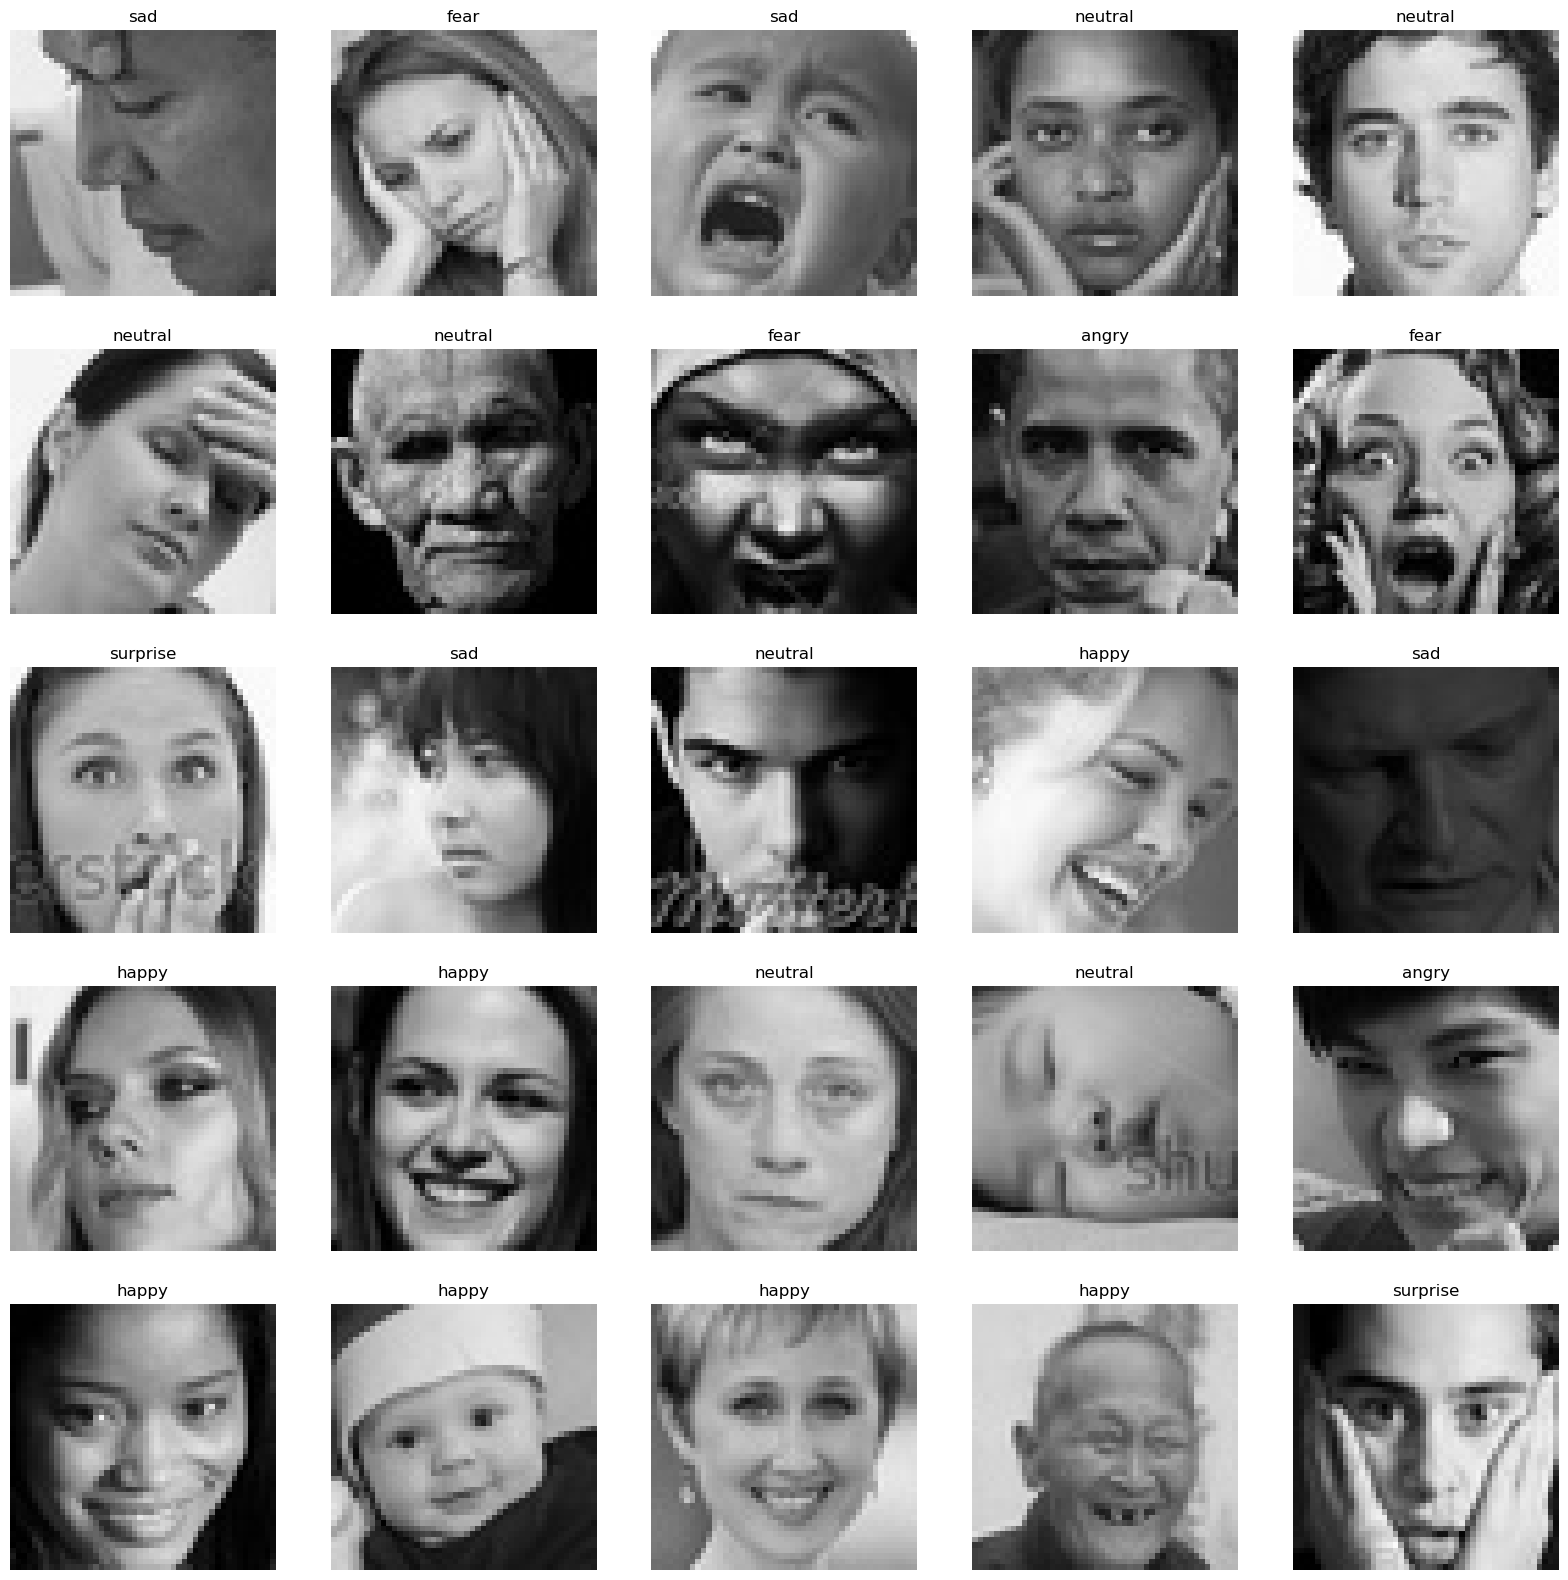

In [9]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [10]:
def extract_features(images):
    # Define data augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=20,  # Rotate the image randomly up to 20 degrees
        width_shift_range=0.2,  # Shift the image horizontally by up to 20% of the width
        height_shift_range=0.2,  # Shift the image vertically by up to 20% of the height
        zoom_range=0.2,  # Zoom in on the image by up to 20%
        horizontal_flip=True,  # Flip the image horizontally
        fill_mode='nearest'  # Fill in missing pixels with the nearest available value
    )
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [11]:
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

In [12]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [13]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [14]:
# convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [15]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [17]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [18]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
# train the model

In [19]:

history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100


2023-04-28 15:29:35.270513: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


226/226 [==============================] - 17s 35ms/step - loss: 1.8258 - accuracy: 0.2426 - val_loss: 1.7986 - val_accuracy: 0.2618
Epoch 2/100
226/226 [==============================] - 7s 33ms/step - loss: 1.7838 - accuracy: 0.2578 - val_loss: 1.6896 - val_accuracy: 0.3053
Epoch 3/100
226/226 [==============================] - 7s 33ms/step - loss: 1.6640 - accuracy: 0.3303 - val_loss: 1.5072 - val_accuracy: 0.4086
Epoch 4/100
226/226 [==============================] - 7s 33ms/step - loss: 1.5216 - accuracy: 0.4078 - val_loss: 1.3765 - val_accuracy: 0.4725
Epoch 5/100
226/226 [==============================] - 8s 34ms/step - loss: 1.4422 - accuracy: 0.4421 - val_loss: 1.3329 - val_accuracy: 0.4866
Epoch 6/100
226/226 [==============================] - 7s 33ms/step - loss: 1.3884 - accuracy: 0.4650 - val_loss: 1.2775 - val_accuracy: 0.5100
Epoch 7/100
226/226 [==============================] - 7s 33ms/step - loss: 1.3513 - accuracy: 0.4838 - val_loss: 1.2526 - val_accuracy: 0.5242
Epo

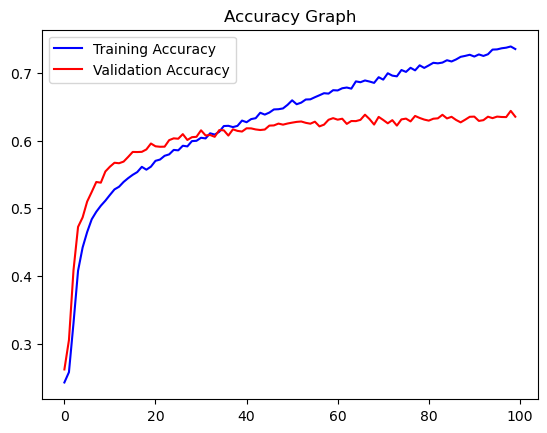

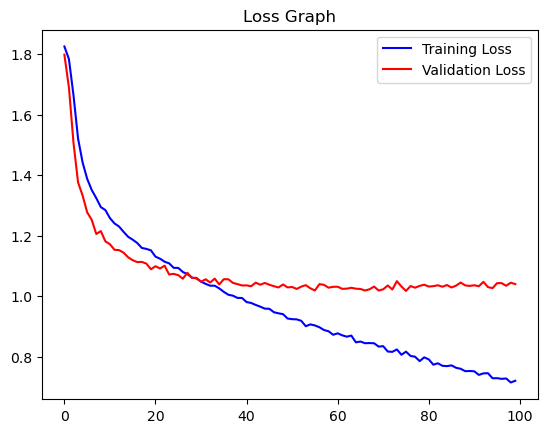

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

In [21]:
model.save('./Saved_model.h5')